#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of handwritten digits (MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook + report) must be submitted through Moodle at least 10 days before the chosen exam date.


#Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

##Imports and Install

In [ ]:
! pip install ray torch torchvision ax-platform sqlalchemy

     |████████████████████████████████| 23.1MB 72.3MB/s 
     |████████████████████████████████| 501kB 52.0MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 2.9MB 52.1MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 133kB 54.4MB/s 
     |████████████████████████████████| 204kB 48.4MB/s 
     |████████████████████████████████| 1.3MB 46.5MB/s 
     |████████████████████████████████| 225kB 53.7MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 296kB 54.7MB/s 
     |████████████████████████████████| 143kB 53.2MB/s 
     |████████████████████████████████| 296kB 49.9MB/s 
     |████████████████████████████████| 102kB 12.0MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp36-none-any.whl size=12622 sha256=357377f4d7ab8b2696f27413e81a9af4066d8c3d020ee508132ea56b8d476616
  Stored in

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from ray import tune
from ray.tune.suggest.ax import AxSearch

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [ ]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

--2020-11-29 10:10:54--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2020-11-29 10:10:55 (89.9 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2020-11-29 10:10:55--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regre

## Dataset

Loading the data:

In [ ]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=0)

All training points:

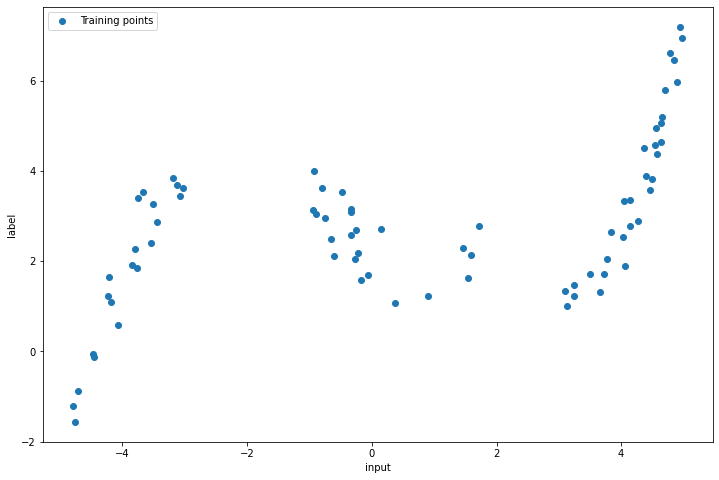

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

All validation points:

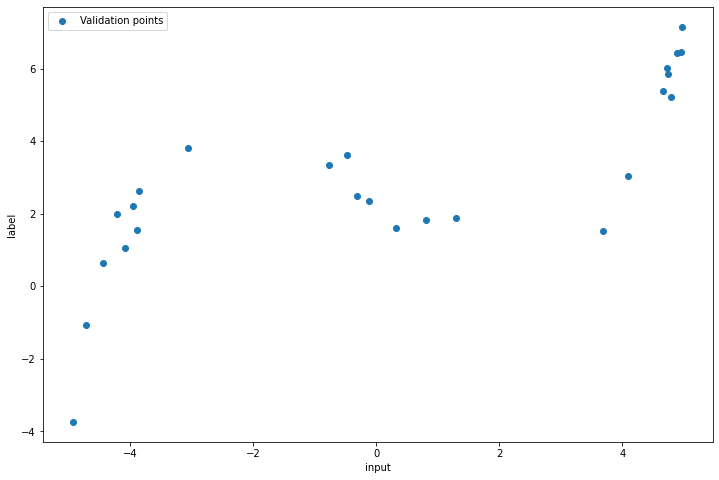

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(val_df.input, val_df.label, label='Validation points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

All test points:

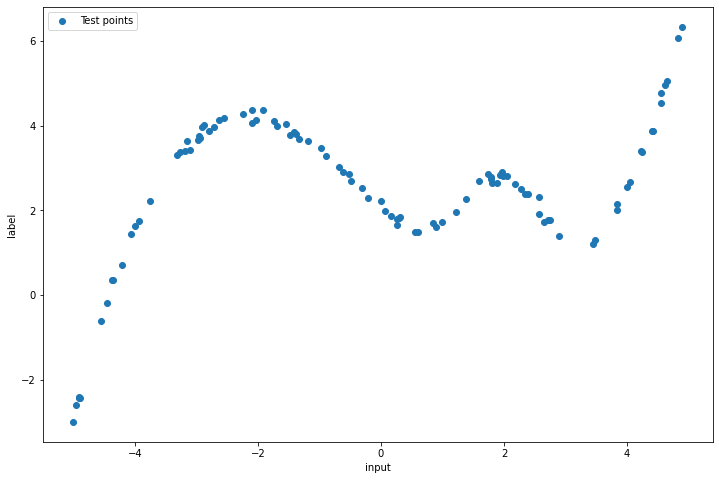

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

In [ ]:
class RegressionDataset(Dataset):

  def __init__(self, dataframe, transform=None):
    self.transform = transform
    self.dataframe = dataframe

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    sample = (self.dataframe.iloc[idx]['input'], self.dataframe.iloc[idx]['label'])
    if self.transform:
      sample = self.transform(sample)
    return sample


class ToTensor(object):

  def __call__(self, sample):
    x, y = sample
    return (torch.tensor([x]).float(),
            torch.tensor([y]).float())

In [ ]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = RegressionDataset(train_df, transform=composed_transform)
val_dataset = RegressionDataset(val_df, transform=composed_transform)
test_dataset = RegressionDataset(test_df, transform=composed_transform)

##Network Definition

In [ ]:
class Net(nn.Module):

  def __init__(self, config):
    super().__init__()

    self.fc1 = nn.Linear(in_features=1, out_features=config['Nh1'])
    self.fc2 = nn.Linear(in_features=config['Nh1'], out_features=config['Nh2'])
    self.out = nn.Linear(in_features=config['Nh2'], out_features=1)
    self.dropout = nn.Dropout(p=config['dropout_p'])
    self.act = nn.Sigmoid()

    nn.init.xavier_uniform_(self.fc1.weight)
    nn.init.xavier_uniform_(self.fc2.weight)
    nn.init.xavier_uniform_(self.out.weight)

    print('Network initialized')

  def forward(self, x):
    x = self.act(self.fc1(x))
    x = self.dropout(x)
    x = self.act(self.fc2(x))
    x = self.dropout(x)
    x = self.out(x)

    return x

##Training

In [ ]:
# Checking device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

# Setting manual seed
torch.manual_seed(0)

Training device: cuda
Sun Nov 29 10:10:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                  

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)

optimization = True

def train(config): 
  net = Net(config)
  net.to(device)

  if optimization:
    train_dataset_local = train_dataset
  else:
    train_df = pd.read_csv('regression_dataset/train_data.csv')
    train_dataset_local = RegressionDataset(train_df, transform=composed_transform)
  
  train_dataloader = DataLoader(train_dataset_local, batch_size=config['train_batch_size'], shuffle=True, num_workers=0)

  # Define the loss function
  loss_fn = nn.MSELoss()

  # Define the optimizer
  optimizer = optim.Adam(net.parameters(), lr=config["lr"])

  epochs = 3000
  train_loss_log = []
  val_loss_log = []

  for epoch in range(epochs):
    ### TRAIN
    train_loss = []
    net.train()

    for sample_batched in train_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      y_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_fn(out, y_batch)

      # Backpropagation
      net.zero_grad()
      loss.backward()

      # Update the weights
      optimizer.step()

      #Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)

    if optimization:
      ### VALIDATION
      val_loss = []
      net.eval()

      with torch.no_grad():
        for sample_batched in val_dataloader:
          # Move data to device
          x_batch = sample_batched[0].to(device)
          y_batch = sample_batched[1].to(device)

          # Forward pass
          out = net(x_batch)

          # Compute loss
          loss = loss_fn(out, y_batch)

          # Save validation loss for this batch
          loss_batch = loss.detach().cpu().numpy()
          val_loss.append(loss_batch)

        # Save average validation loss
        val_loss = np.mean(val_loss)
        val_loss_log.append(val_loss)

      # Send the current training result back to Tune
      tune.report(val_loss=val_loss, train_loss=train_loss)

  # Saving the model
  model_name = f'model_lr={config["lr"]}-Nh1={config["Nh1"]}-Nh2={config["Nh2"]}-dropout_p={config["dropout_p"]}-train_batch_size={config["train_batch_size"]}'
  torch.save(net.state_dict(), f'/content/{model_name}.pth')

  if not optimization:
    return net, train_loss_log

def test(net, config):
  test_loss = []
  net.eval()

  # Define the loss function
  loss_fn = nn.MSELoss()

  # Define the optimizer
  optimizer = optim.Adam(net.parameters(), lr=config["lr"])

  with torch.no_grad():
    for sample_batched in test_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      y_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_fn(out, y_batch)

      # Save test loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      test_loss.append(loss_batch)

    # Save average test loss
    test_loss = np.mean(test_loss)

    print(f'TEST LOSS: {test_loss}')

###Hyper-parameters tuning

In [ ]:
## Used to find optimal hyper-parameters
search_space = {
    'lr': tune.uniform(0.0001, 0.01),
    'Nh1': tune.choice([64, 128, 256]),
    'Nh2': tune.choice([64, 128, 256]),
    'dropout_p': tune.uniform(0, 0.5),
    'train_batch_size': tune.randint(4, 40)
}

## First parameters found optimal
search_space = {
    'lr': 0.0009836242556571962,
    'Nh1': 128,
    'Nh2': 64,
    'dropout_p': 0.01674123853445053,
    'train_batch_size': 10
}

## Final parameters found optimal
search_space = {
    'lr': 0.0009836242556571962,
    'Nh1': 128,
    'Nh2': 64,
    'dropout_p': 0,
    'train_batch_size': 10
}

#Running in optimization mode
optimization = True

ax_search = AxSearch(metric="val_loss", mode='min')
analysis = tune.run(
    run_or_experiment=train,
    config=search_space,
    search_alg=ax_search,
    resources_per_trial={'gpu': 1}, 
    num_samples=1,
    metric='val_loss',
    mode='min',
    verbose=1
)

Trial name,status,loc,Nh1,Nh2,dropout_p,lr,train_batch_size,iter,total time (s),val_loss,train_loss
train_b1a14382,TERMINATED,,128,64,0,0.000983624,10,3000,149.465,0.324259,0.252047


2020-11-29 10:24:21,297	INFO tune.py:439 -- Total run time: 154.88 seconds (150.78 seconds for the tuning loop).


###Trials graphs

BEST: train_b1a14382: {'lr': 0.0009836242556571962, 'Nh1': 128, 'Nh2': 64, 'dropout_p': 0, 'train_batch_size': 10}



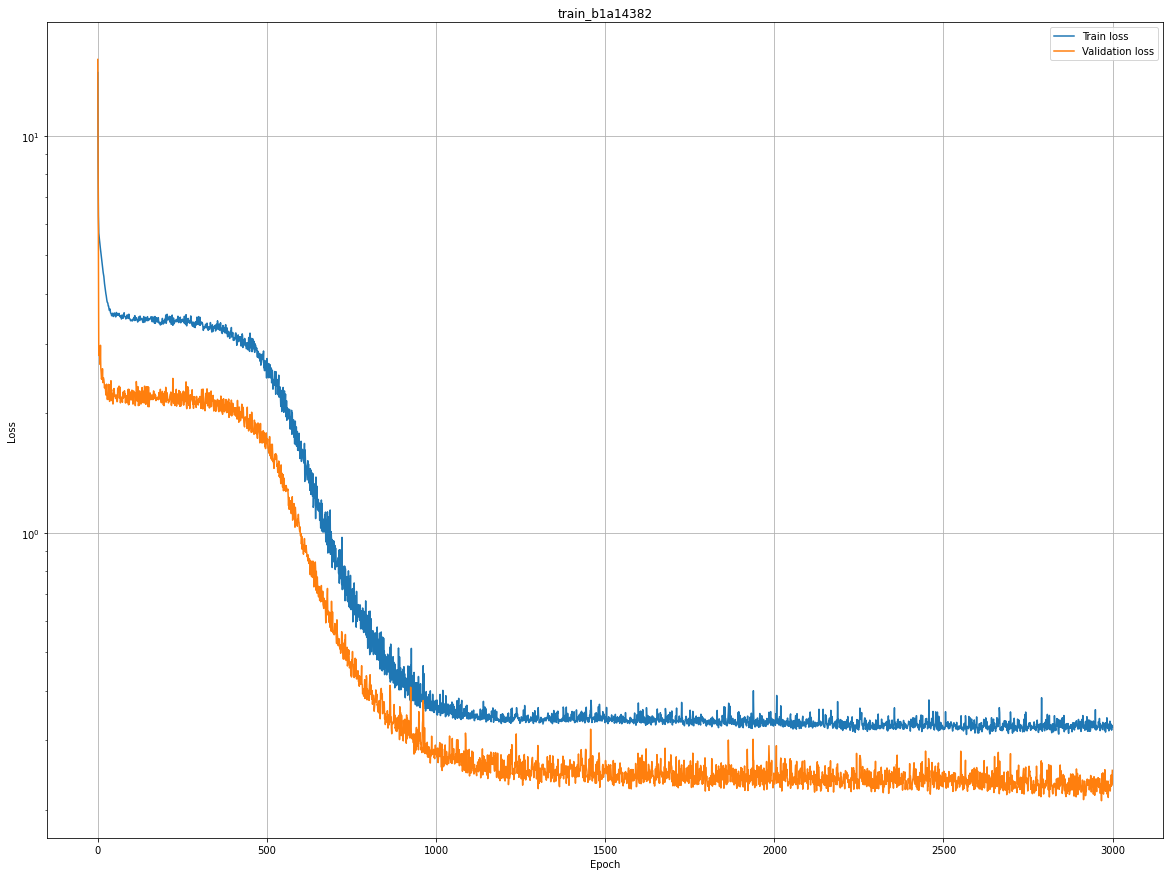

In [ ]:
dfs = analysis.trial_dataframes
print(f'BEST: {analysis.best_trial}: {analysis.best_trial.config}\n')

for index, d in enumerate(dfs.values()):
  plt.figure(figsize=(20,15))
  plt.title(f'{analysis.trials[index]}')
  plt.semilogy(d.val_loss, label='Train loss')
  plt.semilogy(d.train_loss, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()
  plt.show()

###Train and test final model

In [ ]:
optimization = False

net, train_loss_log = train(config)
test(net, config)

Network initialized
TEST LOSS: 0.07081717252731323


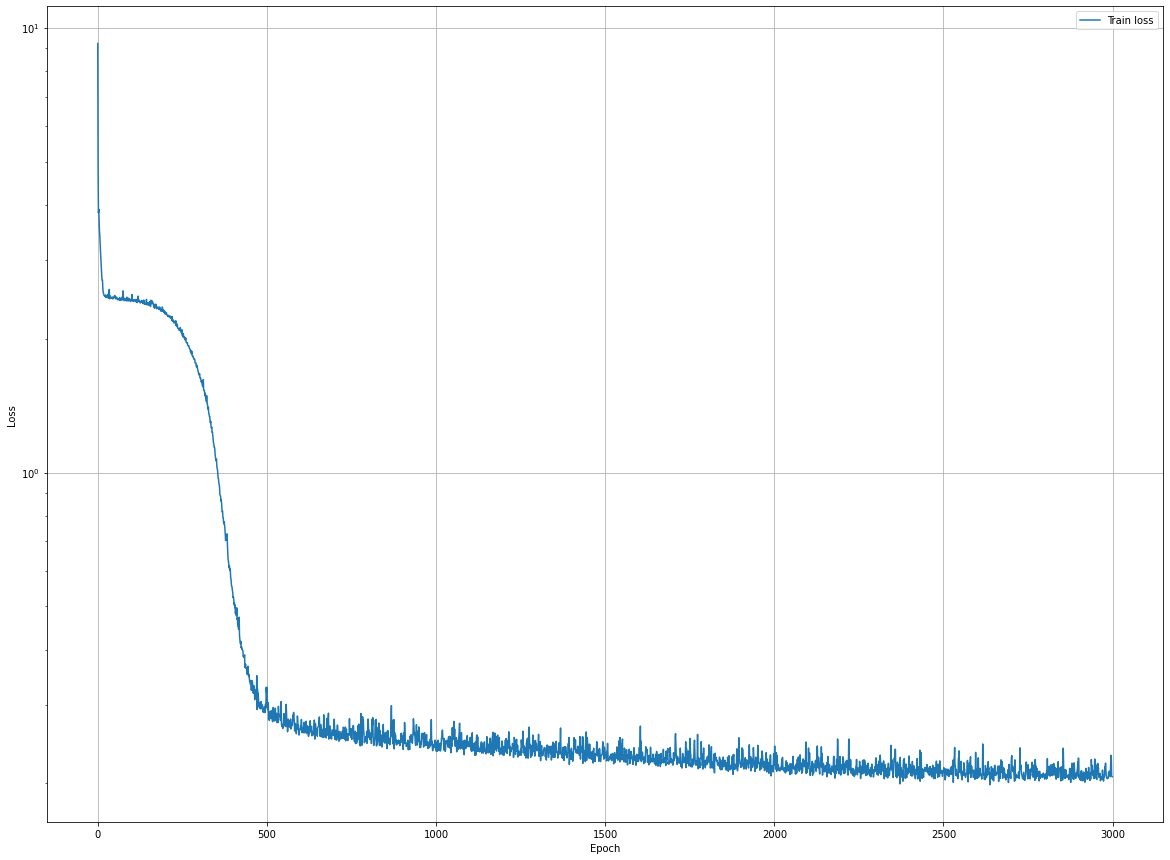

In [ ]:
plt.figure(figsize=(20,15))
plt.title(f'')
plt.semilogy(train_loss_log, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

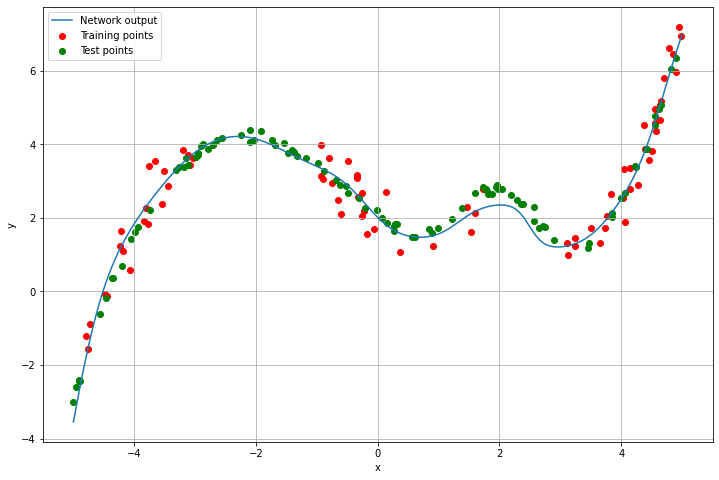

In [ ]:
# Input vector
x_vec = torch.linspace(-5, 5, 1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)

# Network output
with torch.no_grad():
  y_vec = net(x_vec)

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.scatter(train_df.input, train_df.label, label='Training points', color='red')
plt.scatter(test_df.input, test_df.label, label='Test points', color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

##Network analysis

###Weight histograms

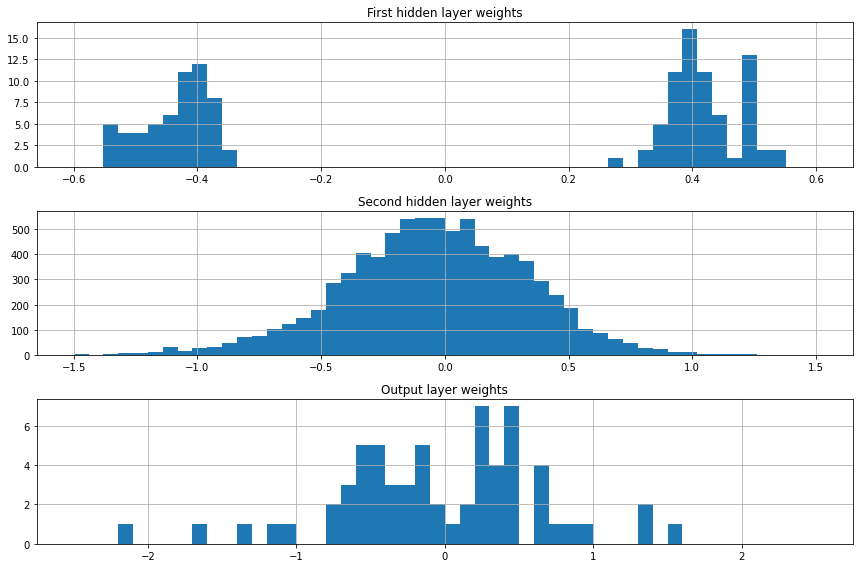

In [ ]:
# Network weights
h1_w = net.fc1.weight.data.cpu().numpy()
h2_w = net.fc2.weight.data.cpu().numpy()
out_w = net.out.weight.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50, range=(-0.6, 0.6))
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50, range=(-1.5, 1.5))
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50, range=(-2.5, 2.5))
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

###Activation profiles

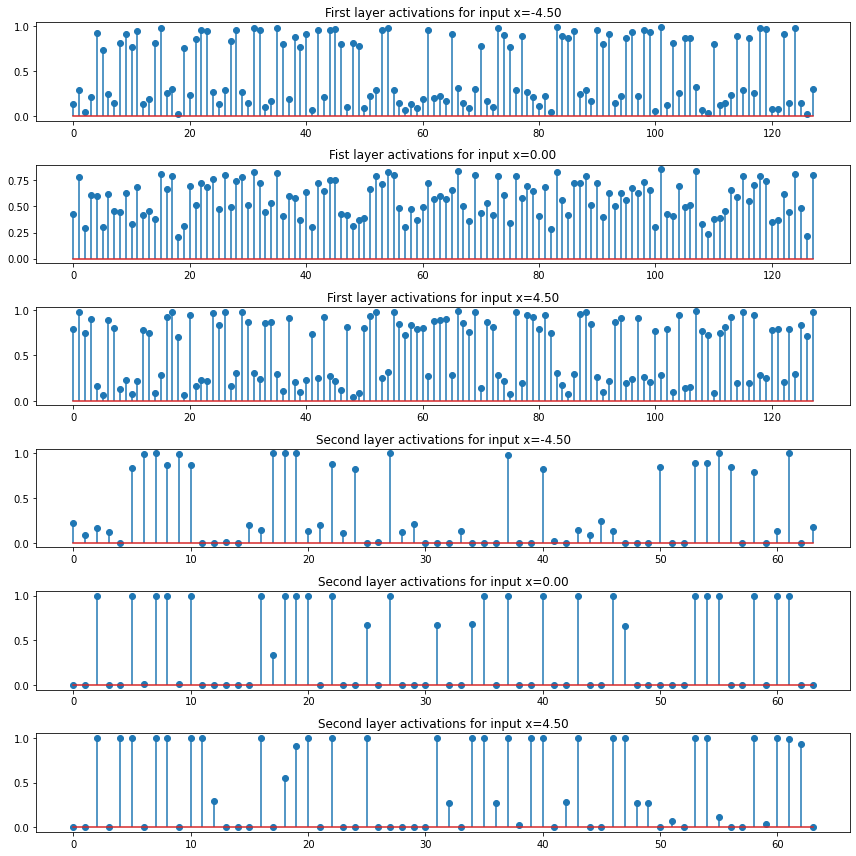

In [ ]:
def get_activation_1(layer, input, output):
    global activation_1
    activation_1 = torch.sigmoid(output)

def get_activation_2(layer, input, output):
    global activation_2
    activation_2 = torch.sigmoid(output)

### Register hooks
hook_handle_1 = net.fc1.register_forward_hook(get_activation_1)
hook_handle_2 = net.fc2.register_forward_hook(get_activation_2)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([-4.5]).float().to(device)
    y1 = net(x1)
    z1_1 = activation_1
    z1_2 = activation_2
    x2 = torch.tensor([0]).float().to(device)
    y2 = net(x2)
    z2_1 = activation_1
    z2_2 = activation_2
    x3 = torch.tensor([4.5]).float().to(device)
    y3 = net(x3)
    z3_1 = activation_1
    z3_2 = activation_2


### Remove hooks
hook_handle_1.remove()
hook_handle_2.remove()

### Plot activations
fig, axs = plt.subplots(6, 1, figsize=(12,12))

axs[0].stem(z1_1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('First layer activations for input x=%.2f' % x1)
axs[1].stem(z2_1.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Fist layer activations for input x=%.2f' % x2)
axs[2].stem(z3_1.cpu().numpy(), use_line_collection=True)
axs[2].set_title('First layer activations for input x=%.2f' % x3)

axs[3].stem(z1_2.cpu().numpy(), use_line_collection=True)
axs[3].set_title('Second layer activations for input x=%.2f' % x1)
axs[4].stem(z2_2.cpu().numpy(), use_line_collection=True)
axs[4].set_title('Second layer activations for input x=%.2f' % x2)
axs[5].stem(z3_2.cpu().numpy(), use_line_collection=True)
axs[5].set_title('Second layer activations for input x=%.2f' % x3)

plt.tight_layout()
plt.show()